<a href="https://colab.research.google.com/github/jbajaj1/faketweets/blob/master/faketweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.utils.data as data
import handleTwitterSent as TS
from torch.utils.data import TensorDataset, DataLoader

In [2]:
twitterVoc = TS.Vocab("twitter")

#Put proper location of file here
tokenizedTweets, tokenizedLabels = TS.load_tweets("../twitter_sentiment/semeval_train_trimmed.txt", Voc=twitterVoc, initVoc=True)

print(twitterVoc.to_word(4))
print(twitterVoc.to_index("this"))

print(twitterVoc.num_words)

beiber
248
25574


In [3]:
from os import listdir
from os.path import isfile, join

emb_list = [16, 32, 64, 128]
hid_list = [16, 32, 64, 128]
num_layers = [1,2,4]
dropout = [0, .1, .2, .3, .4, .5]
completed_models = [f for f in listdir("./models/") if isfile(join("./models/", f)) and ".model" in f]
emb_list = [16, 32]
hid_list = [16,32]
num_layers = [1]
dropout = [.5]
##################
#####Training#####
##################
#(vocab_size, embedding_size, hidden_size, num_layers=2, dropout=0.1)
highPrec = (0, None, None, None)
results_prec = []
for emb in emb_list:
    for hid in hid_list:
        for l in num_layers:
            for d in dropout:
                ourLSTM = TS.LSTM(twitterVoc.num_words, emb, hid, l, d)      
                if f'{emb}_{hid}_{l}_{d}.model' not in completed_models:
                    print(f'Training {emb}_{hid}_{l}_{d}.model')
                    opt = torch.optim.Adam(ourLSTM.parameters(), lr=.1)
                    loss = torch.nn.CrossEntropyLoss()
                    epochs = 30
                    dataset = DataLoader(TensorDataset(tokenizedTweets, tokenizedLabels), batch_size=100)
                    for i in range(epochs):
                        print("Training on epoch", i)
                        for batchidx, (x, y) in enumerate(dataset):
                            opt.zero_grad()
                            outputs = ourLSTM(x)
                            lossVal = loss(outputs, y)
                            lossVal.backward()
                            opt.step()
                    
                    torch.save(ourLSTM.state_dict(), f'./models/{emb}_{hid}_{l}_{d}.model')
                
                else:
                    print(f'Loading {emb}_{hid}_{l}_{d}.model')
                    ourLSTM.load_state_dict(torch.load(f'./models/{emb}_{hid}_{l}_{d}.model'))
                    ourLSTM.eval()
                    print(f'Loaded {emb}_{hid}_{l}_{d}.model')
                
                
                
                ##################
                #####Predict######
                ####Evaluation####
                ##################

                file = "semeval_train_dev.txt"
                
                tokTestTweets, tokTestLabels = TS.load_tweets("../twitter_sentiment/" + file, twitterVoc)
                with torch.no_grad():
                    predVal = ourLSTM(tokTestTweets).argmax(dim=-1)
                prec, conf, neg_F1, pos_F1, F1 = TS.validate(tokTestLabels, predVal)
                results_prec.append(f'Precision with emb_size[{emb}], hid_size[{hid}], layers[{l}], and dropout[{d}]: {prec}')
                if prec > highPrec[0]:
                    highPrec = (prec, conf, len(results_prec) - 1, f'./models/{emb}_{hid}_{l}_{d}.model', neg_F1, pos_F1, F1)
                    


Loading 16_16_1_0.5.model
Loaded 16_16_1_0.5.model
<class 'torch.Tensor'>
Loading 16_32_1_0.5.model
Loaded 16_32_1_0.5.model
<class 'torch.Tensor'>
Loading 32_16_1_0.5.model
Loaded 32_16_1_0.5.model
<class 'torch.Tensor'>
Loading 32_32_1_0.5.model
Loaded 32_32_1_0.5.model
<class 'torch.Tensor'>


Precision with emb_size[16], hid_size[16], layers[1], and dropout[0.5]: 0.5141418055017435
Precision with emb_size[16], hid_size[32], layers[1], and dropout[0.5]: 0.6272762495156916
Precision with emb_size[32], hid_size[16], layers[1], and dropout[0.5]: 0.5249903138318481
Precision with emb_size[32], hid_size[32], layers[1], and dropout[0.5]: 0.6110034870205346
The best performer:
Accuracy: Precision with emb_size[16], hid_size[32], layers[1], and dropout[0.5]: 0.6272762495156916
F1: 0.6184249342373741
NegF1: 0.34525660964230176
PosF1: 0.6296883254094031
Here are the heatmaps



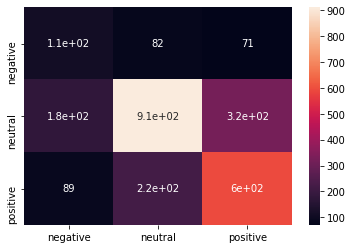

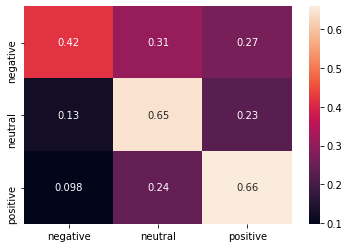

In [4]:
for r in results_prec:
    print(r)
print(f'The best performer:\nAccuracy: {results_prec[highPrec[2]]}\nF1: {highPrec[6]}\nNegF1: {highPrec[4]}\nPosF1: {highPrec[5]}\nHere are the heatmaps\n')

import seaborn as sn
from matplotlib import pyplot as plt

%matplotlib inline

conf = highPrec[1].T
#Counts graph
sn.heatmap(conf, annot=True, xticklabels=["negative", "neutral", "positive"], yticklabels=["negative", "neutral", "positive"])
plt.show()
#Percentages graph
sn.heatmap(conf/conf.sum(1, keepdims=True), annot=True, xticklabels=["negative", "neutral", "positive"], yticklabels=["negative", "neutral", "positive"])
plt.show()


In [5]:


print("Num Unknown Words:", twitterVoc.unknown_count)


Num Unknown Words: 31752
